<a href="https://colab.research.google.com/github/AbhiJeet70/Poison_Airport/blob/main/Poison_Airport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing country: USA
Statistics for USA:
  Number of nodes: 1190
  Number of edges: 13599
  Number of features: 1190
  Number of classes: 4
  Class distribution: [297 297 297 299]
Early stopping at epoch 122
Early stopping at epoch 163
Early stopping at epoch 107
Early stopping at epoch 108
Early stopping at epoch 133
Early stopping at epoch 128
Early stopping at epoch 320
Early stopping at epoch 198
Early stopping at epoch 276
Early stopping at epoch 371
Early stopping at epoch 115
Early stopping at epoch 115
Early stopping at epoch 105
Early stopping at epoch 105
Early stopping at epoch 122
Early stopping at epoch 120
Early stopping at epoch 203
Early stopping at epoch 213
Early stopping at epoch 223
Early stopping at epoch 274
Early stopping at epoch 109
Early stopping at epoch 111
Early stopping at epoch 106
Early stopping at epoch 106
Early stopping at epoch 117
Early stopping at epoch 117
Early stopping at epoch 158
Early stopping at epoch 168
Early stopping at epoch 199
Early

/tmp/ipykernel_34/2261593080.py:234: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Early stopping at epoch 197
Early stopping at epoch 181
Early stopping at epoch 208
Early stopping at epoch 207
Early stopping at epoch 250
Early stopping at epoch 198
Early stopping at epoch 223
Early stopping at epoch 204
Early stopping at epoch 230
Early stopping at epoch 198


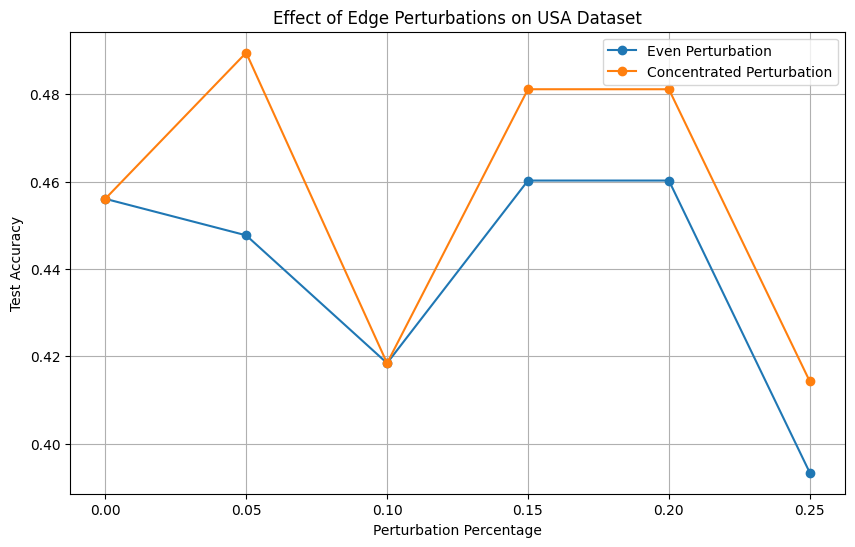

Processing country: Brazil


Processing...
Done!


Statistics for Brazil:
  Number of nodes: 131
  Number of edges: 1074
  Number of features: 131
  Number of classes: 4
  Class distribution: [32 32 32 35]
Early stopping at epoch 120
Early stopping at epoch 123
Early stopping at epoch 107
Early stopping at epoch 114
Early stopping at epoch 101
Early stopping at epoch 174
Early stopping at epoch 221
Early stopping at epoch 240
Early stopping at epoch 104
Early stopping at epoch 112
Early stopping at epoch 116
Early stopping at epoch 131
Early stopping at epoch 107
Early stopping at epoch 111
Early stopping at epoch 126
Early stopping at epoch 131
Early stopping at epoch 201
Early stopping at epoch 234
Early stopping at epoch 101
Early stopping at epoch 321
Early stopping at epoch 124
Early stopping at epoch 113
Early stopping at epoch 104
Early stopping at epoch 104
Early stopping at epoch 121
Early stopping at epoch 136
Early stopping at epoch 263
Early stopping at epoch 171
Early stopping at epoch 265
Early stopping at epoch 271
Early

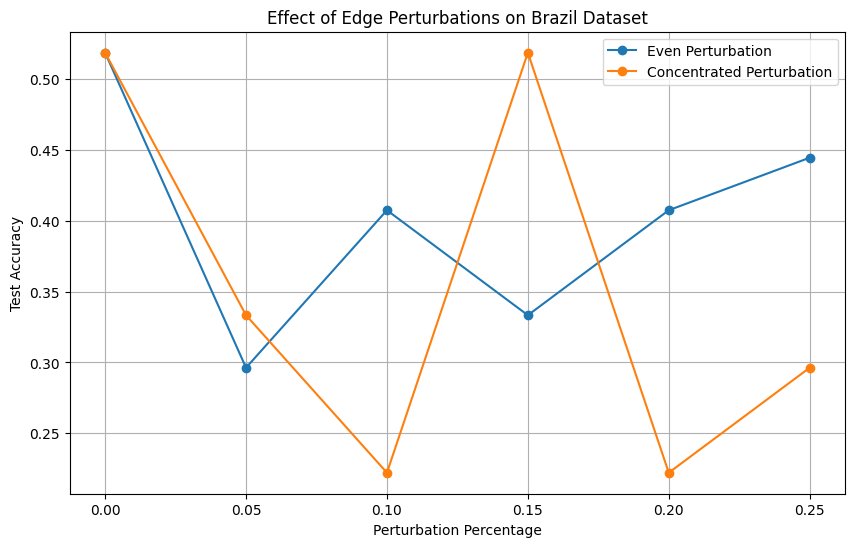

Processing country: Europe


Processing...
Done!


Statistics for Europe:
  Number of nodes: 399
  Number of edges: 5995
  Number of features: 399
  Number of classes: 4
  Class distribution: [ 99  99  99 102]
Early stopping at epoch 297
Early stopping at epoch 191
Early stopping at epoch 142
Early stopping at epoch 188
Early stopping at epoch 101
Early stopping at epoch 101
Early stopping at epoch 108
Early stopping at epoch 104
Early stopping at epoch 101
Early stopping at epoch 117
Early stopping at epoch 209
Early stopping at epoch 165
Early stopping at epoch 132
Early stopping at epoch 143
Early stopping at epoch 101
Early stopping at epoch 101
Early stopping at epoch 103
Early stopping at epoch 101
Early stopping at epoch 103
Early stopping at epoch 108
Early stopping at epoch 168
Early stopping at epoch 173
Early stopping at epoch 106
Early stopping at epoch 106
Early stopping at epoch 112
Early stopping at epoch 207
Early stopping at epoch 153
Early stopping at epoch 101
Early stopping at epoch 102
Early stopping at epoch 101
E

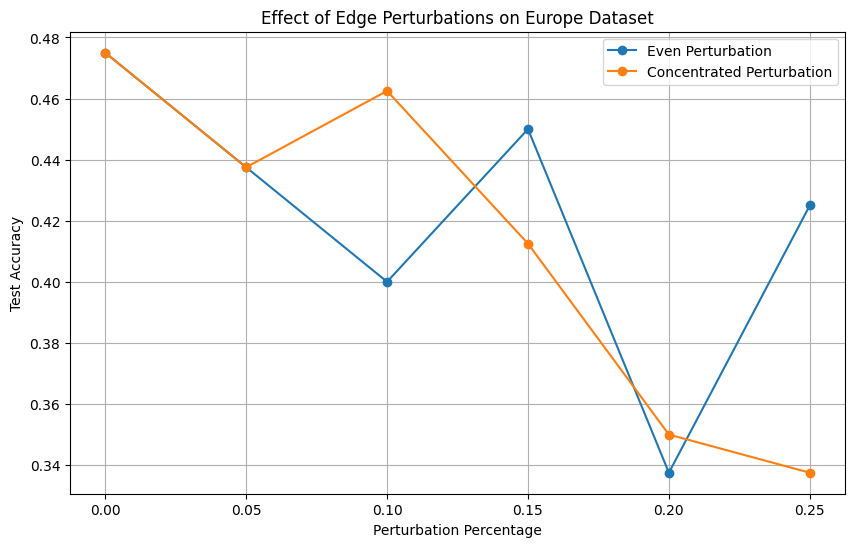

In [ ]:
!pip install torch torch_geometric pandas
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Airports
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(20)

# Define function to load Airports data for a given country
def load_airports_data(country):
    dataset = Airports(root='/tmp/Airports', name=country, transform=NormalizeFeatures())
    data = dataset[0]
    return data

# Split data into train, validation, and test sets (if needed)
def split_indices(num_nodes, train_ratio=0.7, val_ratio=0.1):
    indices = np.random.permutation(num_nodes)
    train_end = int(train_ratio * num_nodes)
    val_end = int((train_ratio + val_ratio) * num_nodes)
    train_idx = torch.tensor(indices[:train_end], dtype=torch.long)
    val_idx = torch.tensor(indices[train_end:val_end], dtype=torch.long)
    test_idx = torch.tensor(indices[val_end:], dtype=torch.long)
    return train_idx, val_idx, test_idx

# Define the GCN model with 2 layers
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train and evaluate the model
def train_model(model, pyg_data, lr, weight_decay):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pyg_data = pyg_data.to(device)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience = 100
    patience_counter = 0

    for epoch in range(1, 501):
        model.train()
        optimizer.zero_grad()
        out = model(pyg_data.x, pyg_data.edge_index)
        loss = F.cross_entropy(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
        val_correct = float(pred[pyg_data.val_mask].eq(pyg_data.y[pyg_data.val_mask]).sum().item())
        val_acc = val_correct / pyg_data.val_mask.sum().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    model.load_state_dict(best_model_state)
    model.eval()
    _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
    correct = float(pred[pyg_data.test_mask].eq(pyg_data.y[pyg_data.test_mask]).sum().item())
    acc = correct / pyg_data.test_mask.sum().item()
    return acc

# Print dataset statistics
def print_dataset_statistics(data, dataset_name):
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    num_features = data.num_node_features
    num_classes = data.y.max().item() + 1
    class_distribution = torch.bincount(data.y).cpu().numpy()
    print(f"Statistics for {dataset_name}:")
    print(f"  Number of nodes: {num_nodes}")
    print(f"  Number of edges: {num_edges}")
    print(f"  Number of features: {num_features}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Class distribution: {class_distribution}")

# Find nodes with the most and fewest degrees
def find_extreme_degree_nodes(edge_index, num_nodes, top_k=20):
    degrees = torch.zeros(num_nodes, dtype=torch.long)
    degrees.scatter_add_(0, edge_index[0], torch.ones(edge_index.size(1), dtype=torch.long))

    top_k_nodes = torch.topk(degrees, top_k).indices
    bottom_k_nodes = torch.topk(degrees, top_k, largest=False).indices
    top_k_degrees = degrees[top_k_nodes]
    bottom_k_degrees = degrees[bottom_k_nodes]

    return top_k_nodes, top_k_degrees, bottom_k_nodes, bottom_k_degrees

def evenly_perturb_edges(data, perturbation_percentage, ascending=False):
    device = data.edge_index.device
    edge_index = data.edge_index.clone().to(device)
    num_edges = edge_index.size(1)
    num_perturbations = int(num_edges * perturbation_percentage)
    total_perturbations = 0

    degrees = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
    degrees.scatter_add_(0, edge_index[0], torch.ones(edge_index.size(1), dtype=torch.long, device=device))
    sorted_nodes = torch.argsort(degrees)

    if not ascending:
        sorted_nodes = sorted_nodes.flip(dims=[0])

    perturbations_per_node = num_perturbations // data.num_nodes

    for node in sorted_nodes:
        if total_perturbations >= num_perturbations:
            break
        connected_edges = (edge_index[0] == node) | (edge_index[1] == node)
        num_node_edges = connected_edges.sum().item()
        num_perturb_node_edges = min(perturbations_per_node, num_node_edges)

        if num_perturb_node_edges > 0:
            perturb_edges_idx = torch.nonzero(connected_edges, as_tuple=False).view(-1)
            perturb_edges_idx = perturb_edges_idx[torch.randperm(perturb_edges_idx.size(0))[:num_perturb_node_edges]]
            edge_index[:, perturb_edges_idx] = torch.randint(0, data.num_nodes, edge_index[:, perturb_edges_idx].shape, dtype=torch.long, device=device)
            total_perturbations += num_perturb_node_edges

    data.edge_index = edge_index
    return data

def concentrated_perturb_edges(data, perturbation_percentage, top_k=20):
    device = data.edge_index.device
    edge_index = data.edge_index.clone().to(device)
    num_edges = edge_index.size(1)
    num_perturbations = int(num_edges * perturbation_percentage)
    total_perturbations = 0

    degrees = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
    degrees.scatter_add_(0, edge_index[0], torch.ones(edge_index.size(1), dtype=torch.long, device=device))
    sorted_nodes = torch.argsort(degrees, descending=True)

    top_k_nodes = sorted_nodes[:top_k]

    for node in top_k_nodes:
        if total_perturbations >= num_perturbations:
            break
        connected_edges = (edge_index[0] == node) | (edge_index[1] == node)
        perturb_edges_idx = torch.nonzero(connected_edges, as_tuple=False).view(-1)
        num_perturb_node_edges = min(len(perturb_edges_idx), num_perturbations - total_perturbations)

        if num_perturb_node_edges > 0:
            perturb_edges_idx = perturb_edges_idx[torch.randperm(len(perturb_edges_idx))[:num_perturb_node_edges]]
            edge_index[:, perturb_edges_idx] = torch.randint(0, data.num_nodes, edge_index[:, perturb_edges_idx].shape, dtype=torch.long, device=device)
            total_perturbations += num_perturb_node_edges

    data.edge_index = edge_index
    return data, top_k_nodes

# Hyperparameter grid search
hidden_channels_list = [64, 128, 256, 512]
learning_rates = [0.01, 0.05, 0.005, 0.001, 0.0005]
weight_decays = [1e-4, 1e-5]

# List of countries to process
countries = ['USA', 'Brazil', 'Europe']

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Country', 'Hidden_Channels', 'Learning_Rate', 'Weight_Decay', 'Accuracy', 'Perturbation_Type', 'Perturbation_Percentage'])

# Process each country and print accuracies
for country in countries:
    print(f'Processing country: {country}')
    data = load_airports_data(country)

    # Print dataset statistics
    print_dataset_statistics(data, country)

    # Prepare the masks
    train_idx, val_idx, test_idx = split_indices(data.num_nodes)
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[train_idx] = True
    data.val_mask[val_idx] = True
    data.test_mask[test_idx] = True

    best_acc = 0
    best_params = None

    # Grid search for best hyperparameters
    for hidden_channels in hidden_channels_list:
        for lr in learning_rates:
            for weight_decay in weight_decays:
                model = GCNNet(data.num_node_features, hidden_channels, data.y.max().item() + 1)
                acc = train_model(model, data, lr, weight_decay)
                if acc > best_acc:
                    best_acc = acc
                    best_params = (hidden_channels, lr, weight_decay)

    print(f"Best accuracy for {country}: {best_acc:.4f} with params {best_params}")

    # Add best model accuracy to the results DataFrame
    new_row = {
        'Country': country,
        'Hidden_Channels': best_params[0],
        'Learning_Rate': best_params[1],
        'Weight_Decay': best_params[2],
        'Accuracy': best_acc,
        'Perturbation_Type': 'None',
        'Perturbation_Percentage': 0
    }
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

    # Perturbation experiments
    perturbation_percentages = [0.05, 0.1, 0.15, 0.2, 0.25]
    perturbation_results = {"Even": [], "Concentrated": []}

    for perturbation_percentage in perturbation_percentages:
        # Even perturbation
        perturbed_data = evenly_perturb_edges(data.clone(), perturbation_percentage)
        model = GCNNet(data.num_node_features, best_params[0], data.y.max().item() + 1)
        even_acc = train_model(model, perturbed_data, best_params[1], best_params[2])
        perturbation_results["Even"].append(even_acc)

        new_row = {
            'Country': country,
            'Hidden_Channels': best_params[0],
            'Learning_Rate': best_params[1],
            'Weight_Decay': best_params[2],
            'Accuracy': even_acc,
            'Perturbation_Type': 'Even',
            'Perturbation_Percentage': perturbation_percentage
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

        # Concentrated perturbation
        perturbed_data, top_k_nodes = concentrated_perturb_edges(data.clone(), perturbation_percentage)
        model = GCNNet(data.num_node_features, best_params[0], data.y.max().item() + 1)
        concentrated_acc = train_model(model, perturbed_data, best_params[1], best_params[2])
        perturbation_results["Concentrated"].append(concentrated_acc)

        new_row = {
            'Country': country,
            'Hidden_Channels': best_params[0],
            'Learning_Rate': best_params[1],
            'Weight_Decay': best_params[2],
            'Accuracy': concentrated_acc,
            'Perturbation_Type': 'Concentrated',
            'Perturbation_Percentage': perturbation_percentage
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot([0] + perturbation_percentages, [best_acc] + perturbation_results["Even"], marker='o', label='Even Perturbation')
    plt.plot([0] + perturbation_percentages, [best_acc] + perturbation_results["Concentrated"], marker='o', label='Concentrated Perturbation')
    plt.xlabel('Perturbation Percentage')
    plt.ylabel('Test Accuracy')
    plt.title(f'Effect of Edge Perturbations on {country} Dataset')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{country}_perturbation_plot.png")
    plt.show()

# Save results to a CSV file
results_df.to_csv('perturbation_results_airports.csv', index=False)
